# **필요한 모듈 불러오기**

In [ ]:
#[1]
#패키지 및 라이브러리 불러오기
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series

In [ ]:
#[2]
#텐서플로우 버전 낮추기
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  

In [ ]:
#[3]
#난수의 시드를 설정
np.random.seed(1871081)
tf.set_random_seed(1871081)

# **학습 데이터 생성하기**

In [ ]:
#[4]
#학습 데이터를 생성하기
def generate_datablock(n, mu, var, t):
  data = multivariate_normal(mu, np.eye(2)*var, n)
  df = DataFrame(data, columns=['x1', 'x2'])
  df['t'] = t
  return df


df0 = generate_datablock(1500, [7,7], 22, 1)
df1 = generate_datablock(1500, [22,7], 22, 0)
df2 = generate_datablock(1500, [7,22], 22, 1)
df3 = generate_datablock(1500, [22,22], 22, 0)

df = pd.concat([df0, df1, df2, df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

In [ ]:
#[5]
#학습 데이터 확인하기
train_set

,x1,x2,t
0,23.427596,22.741209,0
1,23.776994,13.982743,0
2,30.104126,16.461331,0
3,4.693690,22.274932,1
4,22.125463,25.367288,0
...,...,...,...
5995,22.061544,16.714780,0
5996,21.375326,-11.210333,0
5997,4.456913,22.297094,1
5998,15.198451,19.715346,1


In [ ]:
#[6]
#(x1, x2)와 t를 각각 모은 것을 NumPy의 array 오브젝트로 추출해둔다
train_x = train_set[['x1','x2']].to_numpy()
train_t = train_set['t'].to_numpy().reshape([len(train_set), 1])

#**목적함수로 단층 신경망 기반 이항 분류기 모델 정의**

In [ ]:
#[7]
#단층 신경망을 이용한 이항 분류기 모델을 정의한다.
num_units1 = 4
# num_units2 = 2
# num_units3 = 2

mult = train_x.flatten().mean()

x = tf.placeholder(tf.float32, [None, 2])

w1 = tf.Variable(tf.truncated_normal([2, num_units1]))
b1 = tf.Variable(tf.zeros([num_units1]))
hidden1 = tf.nn.selu(tf.matmul(x, w1) + b1*mult)

# w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
# b2 = tf.Variable(tf.zeros([num_units2]))
# hidden2 = tf.nn.leaky_relu(tf.matmul(hidden1, w2) + b2*mult)

# w3 = tf.Variable(tf.truncated_normal([num_units2, num_units3]))
# b3 = tf.Variable(tf.zeros([num_units3]))
# hidden3 = tf.nn.leaky_relu(tf.matmul(hidden2, w3) + b3*mult)


w0 = tf.Variable(tf.zeros([num_units1, 1]))
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden1, w0) + b0*mult)

In [ ]:
p.shape

TensorShape([Dimension(None), Dimension(1)])

# **Loss 함수(비용함수,오차함수), 학습 알고리즘(단계), 정답률 식 정의**

In [ ]:
#[8]
#오차 함수 loss, 트레이닝 알고리즘 train_step, 정답률 accuracy를 정의한다
t = tf.placeholder(tf.float32, [None, 1])
loss = -tf.reduce_sum(t*tf.log(p) + (1-t)*tf.log(1-p))
train_step = tf.train.GradientDescentOptimizer(0.0000001).minimize(loss)
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
#[9]
#세션을 준비하고 Variable을 초기화한다.
sess = tf.InteractiveSession()  #tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# **학습(파라미터 최적화 반복 작업) 수행하기**

In [ ]:
#[10]
#파라미터 최적화를 1000회 반복한다.
i = 0
for _ in range(100000):
  i += 1
  sess.run(train_step, feed_dict={x:train_x, t:train_t})
  if i % 10000 == 0:
    loss_val, acc_val = sess.run([loss, accuracy], feed_dict={x:train_x, t:train_t})
    print('Step: %d, Loss: %f, Accuracy: %f' %(i, loss_val, acc_val))

Step: 10000, Loss: 798.631042, Accuracy: 0.948667
Step: 20000, Loss: 795.796448, Accuracy: 0.949333
Step: 30000, Loss: 795.588745, Accuracy: 0.949333
Step: 40000, Loss: 795.514038, Accuracy: 0.949333
Step: 50000, Loss: 795.451660, Accuracy: 0.949333
Step: 60000, Loss: 795.399963, Accuracy: 0.949333
Step: 70000, Loss: 795.345581, Accuracy: 0.949333
Step: 80000, Loss: 795.277344, Accuracy: 0.949500
Step: 90000, Loss: 795.217407, Accuracy: 0.949500
Step: 100000, Loss: 795.150757, Accuracy: 0.949500


# **확보한 확률을 색의 농담으로 차트 나타내기**


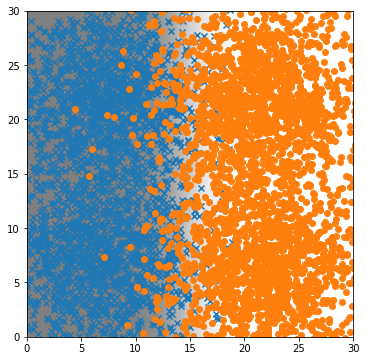

In [ ]:
#[11]
#얻어진 확률을 색의 농담으로 그림에 표시한다.
train_set1 = train_set[train_set['t']==1]
train_set2 = train_set[train_set['t']==0]

fig=plt.figure(figsize=(6,6))
subplot = fig.add_subplot(1,1,1)
subplot.set_ylim([0,30])
subplot.set_xlim([0,30])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set2.x1, train_set2.x2, marker='o')

locations = []
for x2 in np.linspace(0,30,100):
  for x1 in np.linspace(0,30,100):
    locations.append((x1,x2))
p_vals = sess.run(p, feed_dict={x:locations})
p_vals = p_vals.reshape((100,100))
subplot.imshow(p_vals, origin='lower', extent=(0,30,0,30), cmap=plt.cm.gray_r, alpha=0.5)